In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv("../cleaned_DS/Assassin_cleaned.csv")

In [7]:
df['final_text'].isnull().sum()

np.int64(0)

# Data Engineering/Extraction
## TF-IDF Vectorization

In [10]:
tfidf = TfidfVectorizer(
    max_features=5000,    # limit vocabulary size, 5000 features (these features are the most “important” words or n-grams from our corpus)
    ngram_range=(1, 2),   # unigrams + bigrams
    stop_words='english'  # skip common words
)

X_tfidf = tfidf.fit_transform(df['final_text'].fillna(''))
# feature matrix, the numerical representation of all our documents

In [11]:
vocab = tfidf.get_feature_names_out()
print(len(vocab))        # should be ≤ max_features
print(vocab[:20])        # preview first 20 words

5000
['aa' 'aaaa'
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa'
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa'
 'ab' 'abacha' 'ability' 'able' 'absolute' 'absolutely' 'absolutely free'
 'abuse' 'ac' 'academic' 'accept' 'accept apology' 'accepted' 'accepting'
 'access' 'access number']


In [12]:
# View words specifically 
word_vocab = [w for w in vocab if re.match(r'^[a-zA-Z]+$', w)]
print(f"Words only: {len(word_vocab)}")
print(word_vocab[:50])  # preview first 50 words

Words only: 4054
['aa', 'aaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'ab', 'abacha', 'ability', 'able', 'absolute', 'absolutely', 'abuse', 'ac', 'academic', 'accept', 'accepted', 'accepting', 'access', 'accessible', 'accessory', 'accident', 'according', 'account', 'accounting', 'accuracy', 'accurate', 'achieve', 'acquire', 'acquired', 'acquisition', 'act', 'action', 'active', 'actively', 'activist', 'activity', 'actual', 'actually', 'ad', 'adam', 'add', 'added', 'adding', 'addition', 'additional', 'addr', 'address', 'admin', 'administration', 'administrator', 'admit', 'adult']


In [13]:
i = 0  # first email
df_single = pd.DataFrame(X_tfidf[i].T.todense(), index=tfidf.get_feature_names_out(), columns=["tfidf"])
print(df_single[df_single.tfidf > 0]) #Filter to only non-zero TF-IDF scores

                   tfidf
able            0.050441
actually        0.047236
ago             0.054314
au              0.080803
aug             0.048743
...                  ...
wed             0.056341
wed aug         0.072928
work            0.034452
worker          0.060516
worker mailing  0.065785

[72 rows x 1 columns]


In [14]:
sparsity = 1.0 - (X_tfidf.count_nonzero() / (X_tfidf.shape[0] * X_tfidf.shape[1]))
print(f"Sparsity: {sparsity:.2%}")

Sparsity: 98.40%


In [28]:
# tfidf (TfidfVectorizer) and X_tfidf assumed present
feature_names = tfidf.get_feature_names_out()
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=feature_names)

# average TF-IDF in spam vs non-spam
avg_spam = tfidf_df[df['is_spam'] == 1].mean(axis=0)
avg_nonspam = tfidf_df[df['is_spam'] == 0].mean(axis=0)

spam_top = avg_spam.sort_values(ascending=False).head(40)
nonspam_top = avg_nonspam.sort_values(ascending=False).head(40)
print("Top TF-IDF words in spam (avg):")
print(spam_top[:10])
print()
print("Top TF-IDF words in non-spam (avg):")
print(avg_nonspam[:10])

Top TF-IDF words in spam (avg):
click      0.057167
free       0.044397
email      0.043299
mail       0.025424
credit     0.024971
receive    0.024337
address    0.024163
removed    0.023462
rate       0.023387
offer      0.023351
dtype: float64

Top TF-IDF words in non-spam (avg):
aa                                                                                                                                                           0.000831
aaaa                                                                                                                                                         0.000019
aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa                                                                                 0.000000
aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa    0.000000
ab                                                  

In [20]:
y = df['is_spam']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize Logistic Regression
model = LogisticRegression(
    solver='saga', 
    max_iter=5000, 
    penalty='l2',
)

# Fit model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.975

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       818
           1       0.98      0.94      0.96       342

    accuracy                           0.97      1160
   macro avg       0.98      0.96      0.97      1160
weighted avg       0.98      0.97      0.97      1160



In [21]:
train_set = accuracy_score(y_train, model.predict(X_train))
test_set = accuracy_score(y_test, model.predict(X_test))

print("Train accuracy:", train_set)
print("Test set acc:",  test_set)

Train accuracy: 0.9849137931034483
Test set acc: 0.975


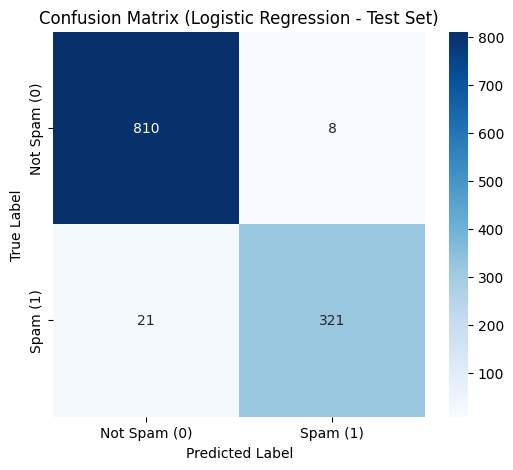

In [26]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Spam (0)', 'Spam (1)'],  
            yticklabels=['Not Spam (0)', 'Spam (1)'])
plt.title('Confusion Matrix (Logistic Regression - Test Set)')     
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [27]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_tfidf, y, cv=cv, scoring='accuracy')

print("Cross-validation accuracies:", scores)
print("Mean accuracy: {:.4f} ± {:.4f}".format(scores.mean(), scores.std()))

Cross-validation accuracies: [0.97672414 0.97068966 0.97068966 0.97586207 0.97758621]
Mean accuracy: 0.9743 ± 0.0030
